In [17]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.contrib.learn.python.learn.estimators import constants
from tensorflow.contrib.learn.python.learn.estimators.dynamic_rnn_estimator import PredictionType
%matplotlib inline



In [31]:
BATCH_SIZE = 1
SEQUENCE_LENGTH = 128

xc = tf.contrib.layers.real_valued_column('')
estimator = tf.contrib.learn.DynamicRnnEstimator(problem_type = constants.ProblemType.LINEAR_REGRESSION,
                                                 prediction_type = PredictionType.MULTIPLE_VALUE,
                                                 sequence_feature_columns = [xc],
                                                 context_feature_columns = None,
                                                 num_units = 128,
                                                 cell_type = 'lstm', 
                                                 optimizer = 'Adam',
                                                 learning_rate = 0.01)



# estimator = tf.contrib.learn.DynamicRnnEstimator(problem_type = constants.ProblemType.CLASSIFICATION,
#                                                  prediction_type = PredictionType.MULTIPLE_VALUE,
#                                                  num_classes = 2,
#                                                  sequence_feature_columns = [xc],
#                                                  context_feature_columns = None,
#                                                  num_units = 128,
#                                                  cell_type = 'lstm', 
#                                                  optimizer = 'Adam',
#                                                  learning_rate = 0.01)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x116316710>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/var/folders/zm/zydy5py918x_dh82qq5s4_j80000gq/T/tmp38ytpm6f'}


In [49]:
prices = np.genfromtxt('prices.csv', delimiter=",")
stances = np.genfromtxt('labels.csv', delimiter=",")

invalid_indices = np.argwhere(np.isnan(stances))
prices = np.delete(prices, invalid_indices)
stances = np.delete(stances, invalid_indices)[1:]
price_diff = np.diff(prices)

def normalise(data):
    mean_val = np.mean(data)
    var_val = np.var(data)
    rescaled = ((data - mean_val) / var_val)
    
    return rescaled


prices_s = normalise(prices)
price_diff_s = normalise(price_diff)
stances_s = normalise(stances)

def get_batches(values, labels, batch_size, n_steps):
    '''Create a generator that returns batches of size
       batch_size x n_steps from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       n_steps: Number of sequence steps per batch
    '''
    # Get the number of characters per batch and number of batches we can make
    items_per_batch = batch_size * n_steps
    n_batches = len(values)//items_per_batch
    
    # Keep only enough characters to make full batches
    values = values[:n_batches * items_per_batch]
    labels = labels[:n_batches * items_per_batch]

    
    # Reshape into batch_size rows
    values = values.reshape((batch_size, -1))
    labels = labels.reshape((batch_size, -1))
    
    for n in range(0, values.shape[1], n_steps):
        # The features
        x = values[:, n:n+n_steps]
        y = labels[:, n:n+n_steps]
        yield x, y
        
n = prices_s.shape[0]
train_idx = int(n * 0.8)
        
train_batches = get_batches(price_diff_s[:train_idx], stances_s[:train_idx], BATCH_SIZE, SEQUENCE_LENGTH)
test_batches = get_batches(price_diff_s[train_idx:], stances_s[train_idx:], BATCH_SIZE, SEQUENCE_LENGTH)


        
def get_train_inputs():
    x, y = next(train_batches)
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    x = tf.expand_dims(x, axis=2)
    y = tf.convert_to_tensor(y, dtype=tf.float32)
#     y = tf.tanh(y)
    return {"": x}, y

def get_test_inputs():
    x, y = next(test_batches)
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    x = tf.expand_dims(x, axis=2)
    y = tf.convert_to_tensor(y, dtype=tf.float32)
#     y = tf.tanh(y)
    return {"": x}, y



[-0.00136621 -0.00143699 -0.00143831 -0.00133672 -0.00131865 -0.00123809
 -0.00124538 -0.00127752 -0.0012922  -0.001401   -0.00133554 -0.00136597
 -0.00144905 -0.00145981 -0.0014383  -0.00141893 -0.00145502 -0.00160923
 -0.00152931 -0.00151175 -0.00153476 -0.00147965 -0.00156419 -0.00150855
 -0.00152605 -0.00147061 -0.0015219  -0.00156465 -0.00160423 -0.00162471
 -0.00161836 -0.00159906 -0.00165413 -0.00164919 -0.00178827 -0.00184211
 -0.00176331 -0.00171636 -0.00180922 -0.0016891  -0.00182457 -0.00184344
 -0.00188437 -0.00188803 -0.00183671 -0.00178934 -0.00179676 -0.00184306
 -0.00180802 -0.00176627] [-0.06890478 -0.00166545  0.09797327  0.01711175  0.0776147  -0.00744305
 -0.03149979 -0.01459035 -0.10572454  0.06299637] [-1.7893224  -1.78433169 -1.77830237 -1.77203055 -1.76758163 -1.76332441
 -1.75998641 -1.75664758 -1.75325271 -1.7493321 ]


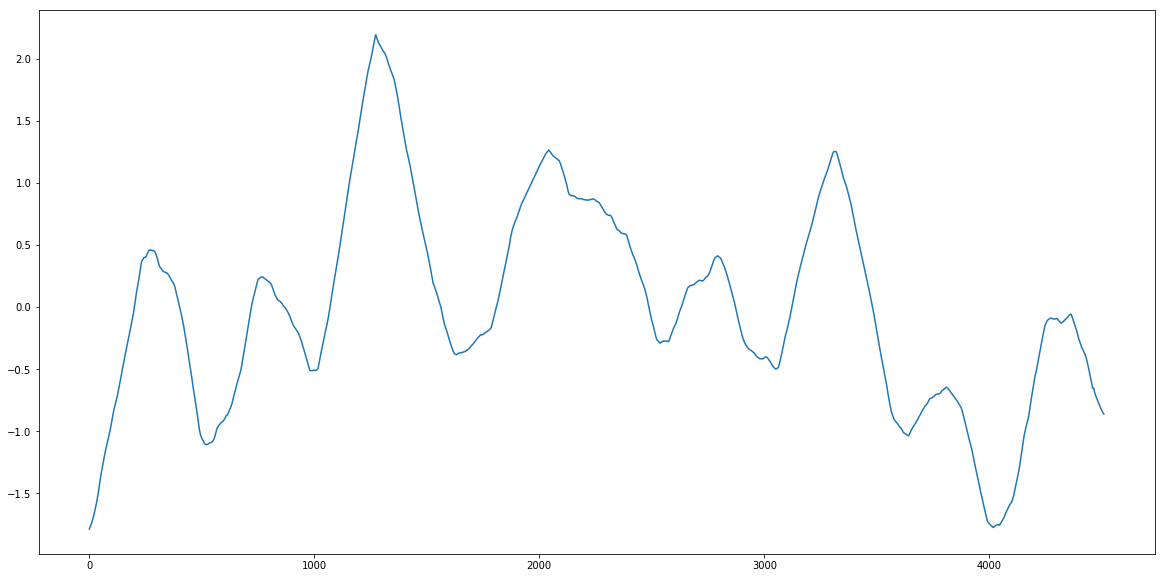

In [33]:
print(prices_s[:50], price_diff_s[:10], stances_s[:10])
pd.Series(stances_s).plot(figsize=(20,10))


In [66]:
estimator.fit(input_fn=get_train_inputs, steps=n)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/zm/zydy5py918x_dh82qq5s4_j80000gq/T/tmp38ytpm6f/model.ckpt-7511
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 7512 into /var/folders/zm/zydy5py918x_dh82qq5s4_j80000gq/T/tmp38ytpm6f/model.ckpt.
INFO:tensorflow:loss = 1.9705038, step = 7512
INFO:tensorflow:global_step/sec: 26.7652
INFO:tensorflow:loss = 0.00021574368, step = 7612 (3.738 sec)
INFO:tensorflow:global_step/sec: 29.8519
INFO:tensorflow:loss = 0.00014728995, step = 7712 (3.350 sec)
INFO:tensorflow:global_step/sec: 29.8972
INFO:tensorflow:loss = 0.00012998444, step = 7812 (3.345 sec)
INFO:tensorflow:global_step/sec: 30.8282
INFO:tensorflow:loss = 0.000116216586, step = 7912 (3.244 sec)
INFO:tensorflow:global_step/sec: 30.5436
INFO:tensorflow:loss = 0.00010419685, step = 8012 (3.274 sec)
INFO:tensorflow:global_step/sec: 

DynamicRnnEstimator(params=None)

In [68]:
evaluated = estimator.evaluate(input_fn=get_test_inputs, steps=1)

INFO:tensorflow:Starting evaluation at 2018-05-18-20:14:41
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/zm/zydy5py918x_dh82qq5s4_j80000gq/T/tmp38ytpm6f/model.ckpt-12022
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-05-18-20:14:42
INFO:tensorflow:Saving dict for global step 12022: global_step = 12022, loss = 0.13815966


In [70]:
type(evaluated)

dict

[[-1.7893224  -1.78433169 -1.77830237 ... -0.85733963 -0.85989006
  -0.86233383]]
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/zm/zydy5py918x_dh82qq5s4_j80000gq/T/tmp38ytpm6f/model.ckpt-12022
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Hello


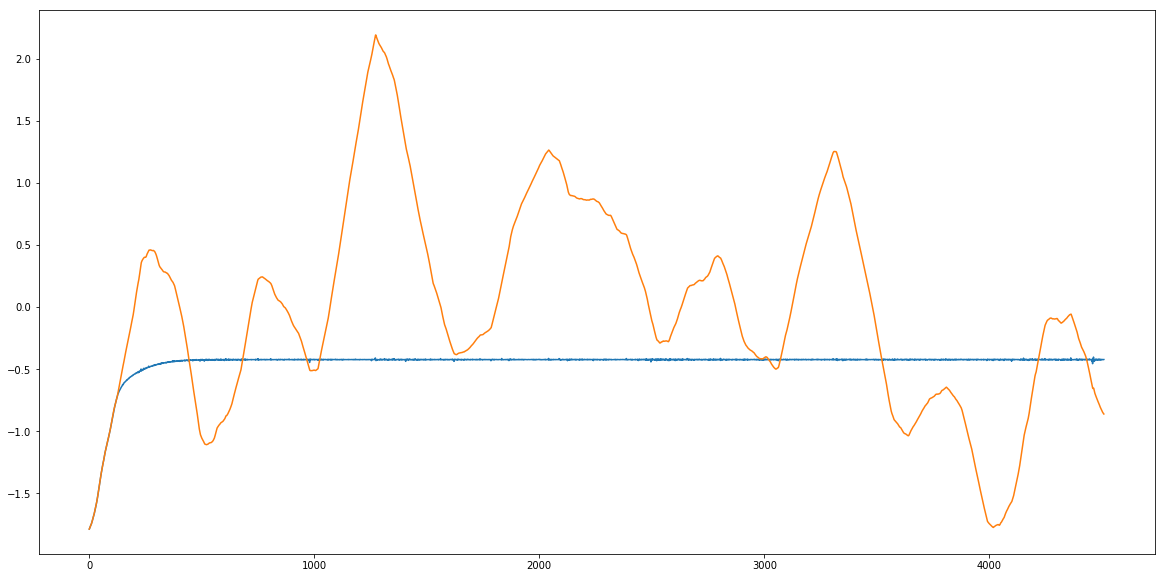

In [71]:
pred_len = price_diff_s.shape[0]
predict_batches = get_batches(price_diff_s, stances_s, 1, pred_len)

def get_predict_inputs():
    x, y = next(predict_batches)
    print(y)
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    x = tf.expand_dims(x, axis=2)
    return {"": x}

predict = estimator.predict(input_fn=get_predict_inputs)
scores = next(predict)['scores']
pd.Series(scores).plot(figsize=(20,10))
pd.Series(stances_s).plot(figsize=(20,10))

print('Hello')


In [59]:
x

{'rnn_cell_state_0': array([ 2.97877030e-03, -4.63971645e-02,  1.49554178e-01, -6.11061184e-03,
        -1.52440239e-02,  2.32767430e-04,  2.42253259e-01,  2.12657079e-02,
         9.76217747e-01,  3.99542926e-03,  1.02710053e-02, -1.80345178e+00,
         3.47272697e-04, -1.80159099e-02, -4.30254079e-03,  8.73106766e+00,
         5.64286672e-03,  2.80812550e+00,  6.38328819e-03,  3.58674787e-02,
        -1.82387090e+00, -5.57995367e+00,  8.77307821e-03,  2.50160545e-02,
        -1.05531272e-02, -1.31283812e-02,  1.51996864e-02, -2.01363303e-03,
         1.07594131e+02, -1.46168086e-03, -1.76434368e-02,  1.70828663e-02,
         1.29998587e-02, -2.38457001e+02,  1.16712487e+00,  2.58110818e-02,
        -4.39145863e-02, -2.02730998e-01,  5.88352233e-03, -8.63224506e-01,
         2.52298641e+00,  1.21906411e-03,  5.26496544e-02, -3.04453230e+00,
         1.86410788e-02, -1.29834830e-03,  9.94122028e-02, -1.72516748e-01,
         1.60439663e+01,  1.64162769e+01, -1.74911141e-01, -2.193027